<a href="https://colab.research.google.com/github/smidmaja/Learning-PyTorch/blob/main/Learning-PyTorch/notebooks/Learning_PyTorch_NNClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting wether something is one thing or another (there can be multiple things as the options).

Book version of this notebook - https://www.learnpytorch.io/02_pytorch_classification/
All other resources - https://github.com/mrdbourke/pytorch-deep-learning


## 1. Make classification data and get ready

In [97]:
import sklearn

In [98]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)


In [99]:
len(X), len(y)

(1000, 1000)

In [100]:
print(f"First 5 samples of X:\n {X[:5]} ")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] 
First 5 samples of y:
 [1 1 1 1 0]


In [101]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], #this is a dictionary
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


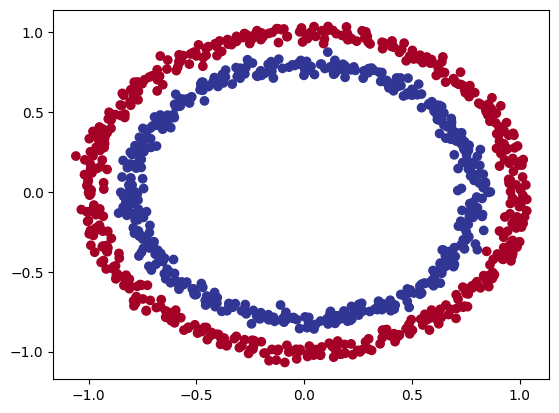

In [102]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

**Note**: The data we're working with is often referred to as a toy data set, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [103]:
X.shape, y.shape

((1000, 2), (1000,))

In [104]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [105]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X{X_sample.shape} and the same for y: {y_sample.shape}") # y is a scalar so it doesnt have a shape

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X(2,) and the same for y: ()


### 1.2 Turn data into tensors and create a train and test split


In [106]:
import torch
torch.__version__

'2.9.0+cu126'

In [107]:
type(X), X.dtype # usually its float64

(numpy.ndarray, dtype('float64'))

In [108]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # because X is a numpy array, we need the datatype to be float32
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [109]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [110]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, # the order is fixed, always use this order
                                                    y,
                                                    test_size=0.2, # 0.2=20% of data will be test & 80% will be train
                                                    random_state=42) # 0.2=20% of data will be test & 80% will be train

In [111]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model(by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [112]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [113]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

In [114]:
X_train.shape # X has 800 samples with 2 features each

torch.Size([800, 2])

In [115]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

Now we've set up device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Moduel`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forwards()` method that outlines the forward pass (or forwards computation) of the model
4. Instantiate an instance of our model class and send it to the target device

In [116]:
from sklearn import datasets
# 1. Construct a model that subclasses nn.Module
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
                                                            # (the more hidden features the more opportunity our model has to learn patterns)
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [117]:
# Another option:
'''
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.two_linear_layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=5),
        nn.Linear(in_features=5, out_features=1)
    )

  def forward(self, x):
    return two_linear_layers(x)
'''

'\nclass CircleModelV2(nn.Module):\n  def __init__(self):\n    super().__init__()\n\n    self.two_linear_layers = nn.Sequential(\n        nn.Linear(in_features=2, out_features=5),\n        nn.Linear(in_features=5, out_features=1)\n    )\n\n  def forward(self, x):\n    return two_linear_layers(x)\n'

In [118]:
device

'cuda'

In [119]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [120]:
# Lets replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [121]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [122]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 labels: \n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [123]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regression you might want MAE or MSE (mean absolute error or mean squared error).and

For classification you might want binary cross entropy or caregorical cross entropy (cross entropy).

As a reminder, the loss function measures how *wrong* your models bredictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For some common choices of loss functions and optimizers -  https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer
* For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a/
* For a definition on what a logit is in deep learning - https://stackoverflow.com/a/52111173
* For different optimizers see `torch.optim`

In [124]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone trough the sigmoid activation function prior to input to BCELoss

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLOgitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1
                            )

In [125]:
# Calculate accuracy - out of 100 examples, what percentage does out model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # checks how many from y_true equal y_pred and then sums it up and get the item bc we want is as a single value in python
  acc = (correct / len(y_pred)) * 100
  return acc


## 3. Train model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagartion)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probabilities by passing them to some kind of activiation function (e.g. sigmoid for binary classification  and softmax for multiclass classification).

Then we ca convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [126]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [127]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [128]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

For our prediction probabiloty values, we need to perform a range-style rounding on them:
* `y_pred_prods`>= 0.5, `y=1` (class 1)
* `y_pred_probs`< 0., `y=0` (class 0)


In [129]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

### 3.2 Building a training and testing loop

In [130]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probabilities -> pred labels

  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # if we would use nn.BCELoss, it expects prediction probabilities as input
  #               y_train)
  loss = loss_fn(y_logits,
                 y_train ) # BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropabagtion)
  loss.backward()

  # 5. Opimizer step (gradient descent)
  optimizer.step()


  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the test loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Training Loss: {loss:.5f}, Training Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}% ")

Epoch: 0 | Training Loss: 0.69796, Training Acc: 51.88% | Test loss: 0.69440, Test acc: 58.00% 
Epoch: 100 | Training Loss: 0.69331, Training Acc: 49.25% | Test loss: 0.69271, Test acc: 53.00% 
Epoch: 200 | Training Loss: 0.69310, Training Acc: 50.88% | Test loss: 0.69336, Test acc: 49.00% 
Epoch: 300 | Training Loss: 0.69304, Training Acc: 51.12% | Test loss: 0.69376, Test acc: 46.50% 
Epoch: 400 | Training Loss: 0.69301, Training Acc: 51.25% | Test loss: 0.69403, Test acc: 47.50% 
Epoch: 500 | Training Loss: 0.69299, Training Acc: 50.88% | Test loss: 0.69423, Test acc: 47.00% 
Epoch: 600 | Training Loss: 0.69299, Training Acc: 51.25% | Test loss: 0.69436, Test acc: 46.50% 
Epoch: 700 | Training Loss: 0.69298, Training Acc: 51.25% | Test loss: 0.69446, Test acc: 46.00% 
Epoch: 800 | Training Loss: 0.69298, Training Acc: 51.50% | Test loss: 0.69453, Test acc: 45.50% 
Epoch: 900 | Training Loss: 0.69298, Training Acc: 51.38% | Test loss: 0.69458, Test acc: 45.00% 


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

To do so, we're going to import a function calles `plot_decision_boundary()`

In [131]:
import requests
from pathlib import Path

# Download helper functions from PyTorch repo (if its not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open ("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


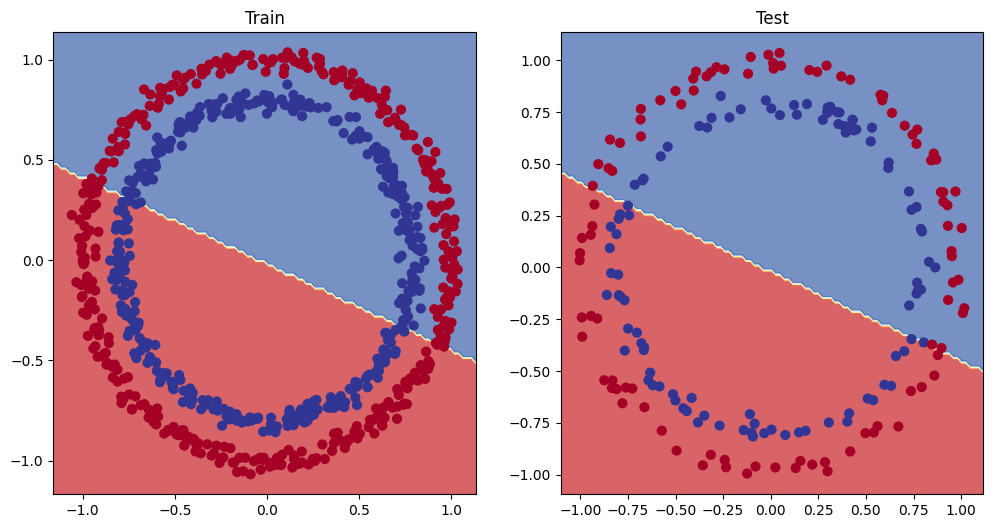

In [132]:
# plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a models perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units- go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred to as **hyperparameters**. (the parameters we can change such as units, functions ect.)

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000


In [133]:
X_train[:5], y_train[:5] # we have two input features and one output feature

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]], device='cuda:0'),
 tensor([1., 0., 0., 0., 1.], device='cuda:0'))

In [134]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x): # passing data trough the layers defined above and overrides z each time its assigned newly
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # but this way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [135]:
# Create a loss functions
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [136]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()
  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward Pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate the loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out whats happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}% ")

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00% 
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00% 
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00% 
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00% 
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00% 
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00% 
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00% 
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00% 
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00% 
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00% 


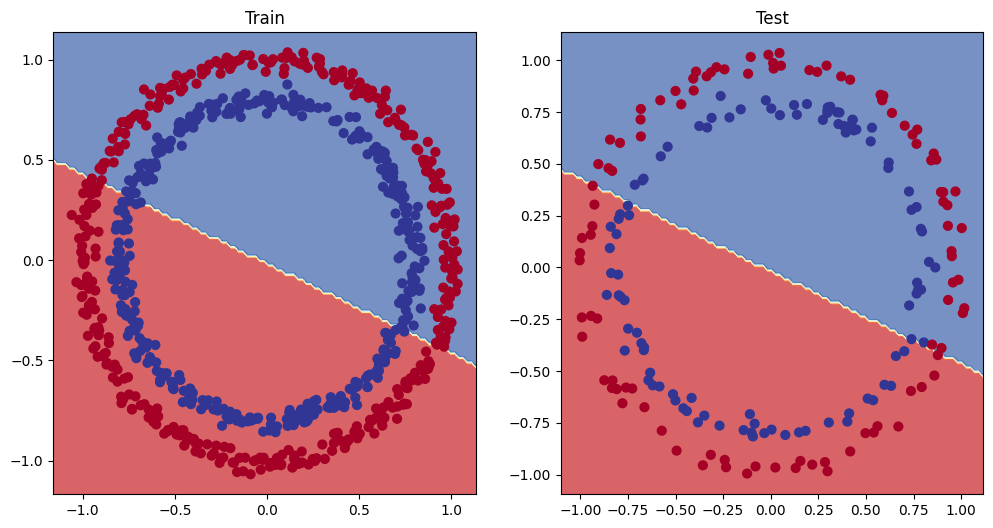

In [137]:
# Plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem.

In [138]:
# Create some data (same as Notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear Regression formul (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [139]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

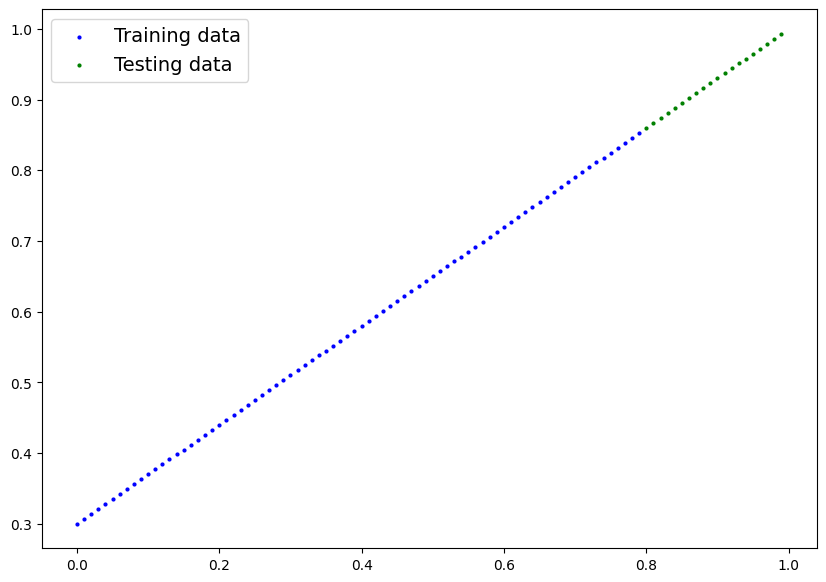

In [140]:
plot_predictions(
    train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression,
    predictions=None
);

In [141]:
X_train_regression[:5], y_train_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

### 5.2 Adjusting `model_1`to fit a straight line

In [142]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [143]:
# Loss and optimizer
loss_fn = nn.L1Loss() # MAE Loss with regression data
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

In [144]:
# xrain the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.91103
Epoch: 100 | Train loss: 0.02858, Test loss: 0.00081
Epoch: 200 | Train loss: 0.02533, Test loss: 0.00209
Epoch: 300 | Train loss: 0.02137, Test loss: 0.00305
Epoch: 400 | Train loss: 0.01964, Test loss: 0.00341
Epoch: 500 | Train loss: 0.01940, Test loss: 0.00387
Epoch: 600 | Train loss: 0.01903, Test loss: 0.00379
Epoch: 700 | Train loss: 0.01878, Test loss: 0.00381
Epoch: 800 | Train loss: 0.01840, Test loss: 0.00329
Epoch: 900 | Train loss: 0.01798, Test loss: 0.00360


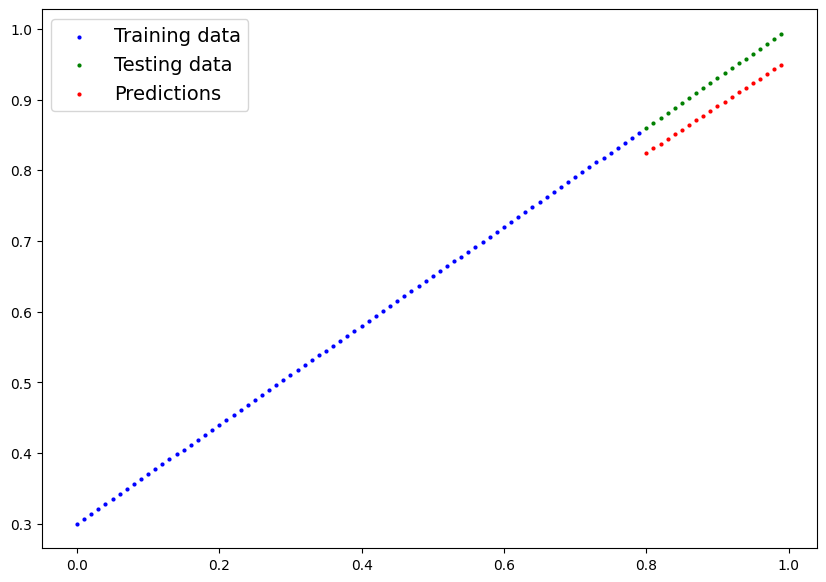

In [145]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (Inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of a straight and non-straigt lines?"

Or in machine learning terms, an infinite amount (but really it is finite) of linear and non-linear functions?



### 6.1 Recreating non-linear data (red and clue circles)

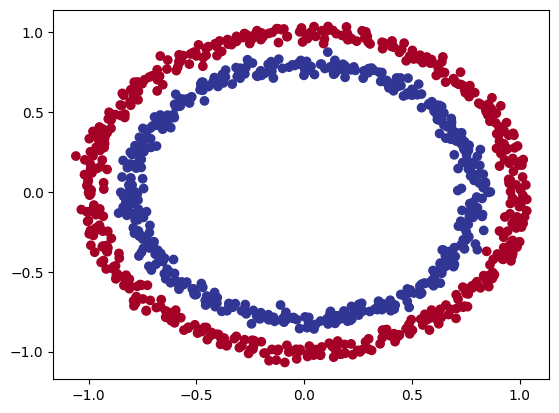

In [146]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [147]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = straigth lines
* Non-Linear = non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.


In [148]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [149]:
# setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)


### 6.3 Training a model with non-linearity


In [150]:
len(X_test), len(y_test)

(200, 200)

In [151]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():

      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels

      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Acc: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Acc: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Acc: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Acc: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Acc: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Acc: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Acc: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Acc: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Acc: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Acc: 79.00%


In [152]:
### 6.4 Evaluating a model trained with non-linear activation functions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

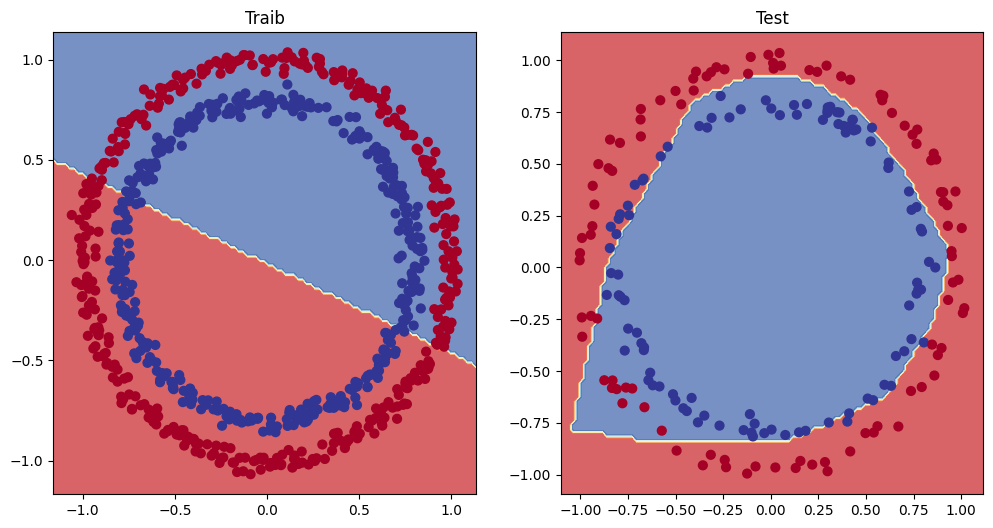

In [153]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Traib")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

**Challange:** Can you improve model_3 to do better than 80% accuracy on the test data? (i did it by changing the amound of hidden layers to 20)

## 7. Replicating non-linear actvation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions.

In [154]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype = torch.float32)
A.dtype

torch.float32

In [155]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

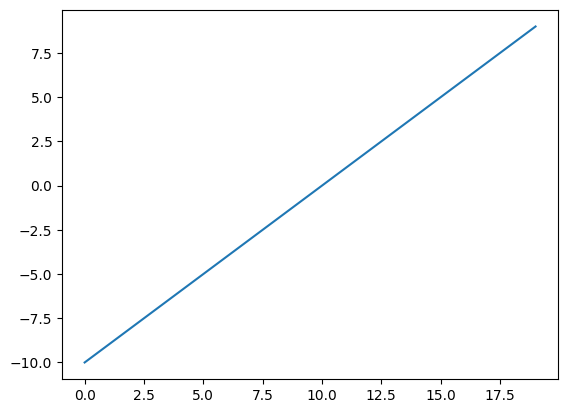

In [156]:
# Visualize this data
plt.plot(A);

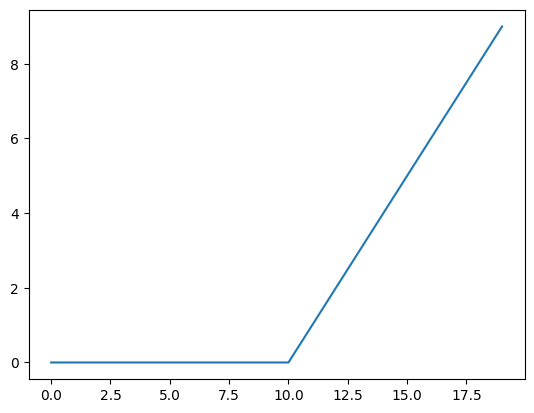

In [157]:
plt.plot(torch.relu(A));

In [158]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

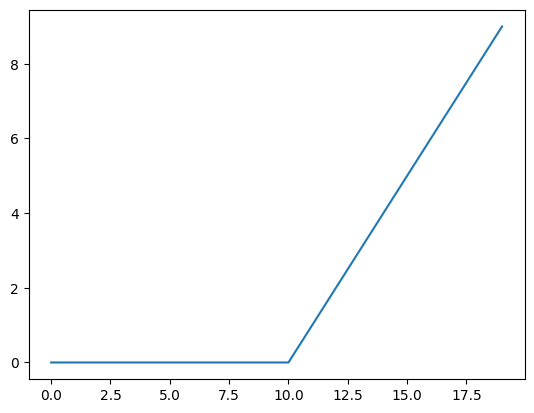

In [159]:
# Plot ReLu actovation function
plt.plot(relu(A));

In [160]:
# Now let's do the same for sigmoid: https://docs.pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

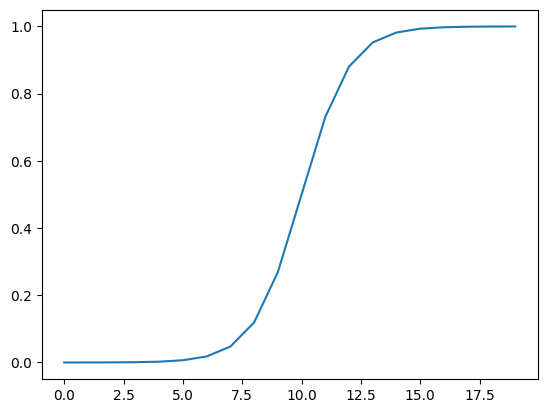

In [161]:
plt.plot(torch.sigmoid(A));

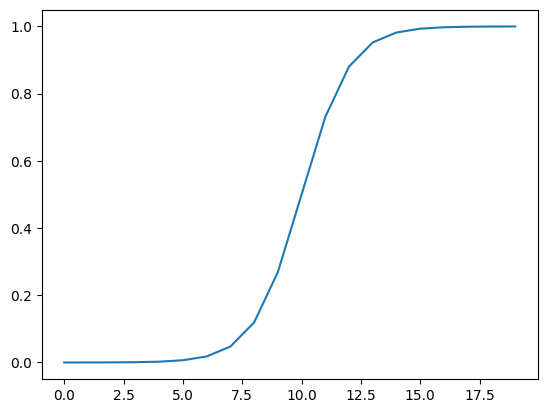

In [162]:
plt.plot(sigmoid(A));

## 8. Putting it all together with a multi-class classification problem
* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud vs not fraud)
* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

### 8.1 Creating a toy multiclass dataset

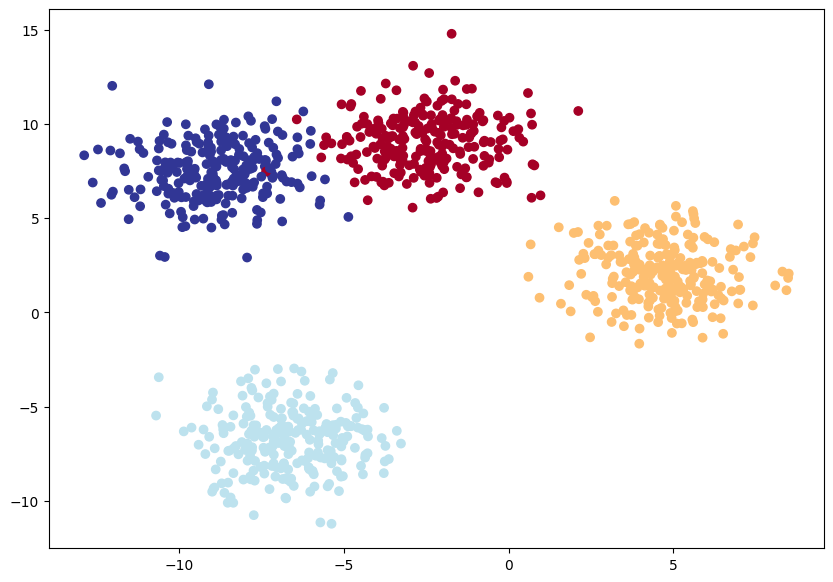

In [163]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split data into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualize)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model in PyTorch

In [164]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [165]:
# Build a multi class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (numver of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [166]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [167]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [168]:
# Create a loss function for multi-class classification - loss function measures how wrong our predictions are
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1) # learning rate is a hyperparameter you can change

### 8.4 Getting prediction probabilities for a mutli-class PyTorch model

In order to evaluate and train our model, we need to convert our model's output (logits) to predictions probabilities and the to prediction labels.

Logits (raw output of the model) -> pred probs (use `torch.softmax`) -> pred labels (take the argmax of the prediction probabilities)

In [169]:
# Let's get some raw outputs of our model(logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [170]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [171]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [172]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Create a training loop and testing loop for a multi-class PyTorch model

In [173]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop trough data
for epoch in range (epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                          y_pred=test_preds)

    # Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss: .4f}, Acc: {acc: .2f}% | Test Loss: {test_loss: .4f}, Test accuracy: {test_acc: .2f}%")


Epoch: 0 | Loss:  1.1588, Acc:  40.38% | Test Loss:  1.0755, Test accuracy:  48.00%
Epoch: 10 | Loss:  0.6448, Acc:  96.75% | Test Loss:  0.6607, Test accuracy:  97.50%
Epoch: 20 | Loss:  0.4254, Acc:  98.50% | Test Loss:  0.4307, Test accuracy:  100.00%
Epoch: 30 | Loss:  0.2529, Acc:  99.12% | Test Loss:  0.2451, Test accuracy:  99.50%
Epoch: 40 | Loss:  0.1123, Acc:  99.25% | Test Loss:  0.1023, Test accuracy:  99.50%
Epoch: 50 | Loss:  0.0663, Acc:  99.25% | Test Loss:  0.0585, Test accuracy:  99.50%
Epoch: 60 | Loss:  0.0507, Acc:  99.25% | Test Loss:  0.0429, Test accuracy:  99.50%
Epoch: 70 | Loss:  0.0430, Acc:  99.25% | Test Loss:  0.0349, Test accuracy:  99.50%
Epoch: 80 | Loss:  0.0384, Acc:  99.25% | Test Loss:  0.0299, Test accuracy:  99.50%
Epoch: 90 | Loss:  0.0352, Acc:  99.25% | Test Loss:  0.0266, Test accuracy:  99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model


In [174]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [175]:
# Go from logits -> prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [176]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

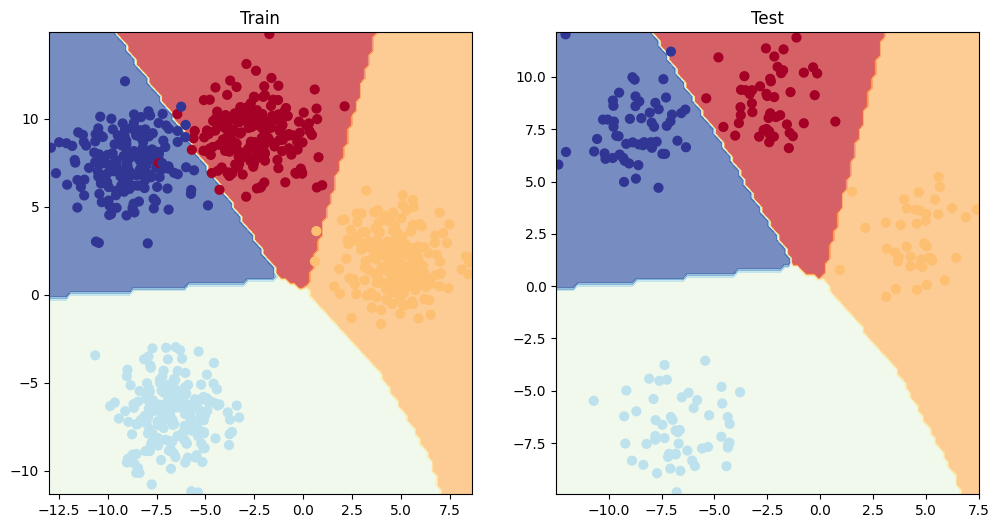

In [177]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, hopw many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

See this article for when to use precision/recall - https://medium.com/data-science/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you want access to a lot of pytorch metrics - https://lightning.ai/docs/torchmetrics/stable/

In [178]:
!pip install torchmetrics

In [179]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

## Exercises & Extracurriculum

See exercises and extracurriculum here: https://www.learnpytorch.io/02_pytorch_classification/#exercises